In [1]:
!pip install dm-sonnet dm-tree


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.4/268.4 kB 4.9 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tree

import matplotlib.image as mpimg
import scipy.stats as stats
import matplotlib.pyplot as pl

from sklearn.model_selection import train_test_split

try:
  import sonnet.v2 as snt
  tf.enable_v2_behavior()
except ImportError:
  import sonnet as snt

print("TensorFlow version {}".format(tf.__version__))
print("Sonnet version {}".format(snt.__version__))

TensorFlow version 2.15.0
Sonnet version 2.0.2


In [3]:
tf.keras.backend.set_floatx('float32')

# data

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import os
os.chdir("/content/drive/MyDrive/data_exchange/")

Mounted at /content/drive


In [5]:
dataset = np.float32(np.load('pv4.npy')[::50,])

In [6]:
def norm_train(x,min_x,max_x):
  return (x-min_x)/(max_x-min_x)-0.5
  #-0.5 0.5

In [7]:
# normalize data
dataset =norm_train(dataset,dataset.min(),dataset.max())

# split train/val/test
train_data_dict, test_data_dict = train_test_split(dataset, test_size=0.15)
test_data_dict, valid_data_dict = train_test_split(test_data_dict, test_size=0.05)

In [8]:
dataset_bad = np.float32(np.load('pv2.npy')[::50,])

In [9]:
dataset_bad = norm_train(dataset_bad,dataset_bad.min(),dataset_bad.max())

In [10]:
nx = dataset.shape[1]

In [ ]:
# dataset_shuffle = dataset.copy()
# np.random.shuffle(dataset_shuffle)

In [ ]:
# train_data_dict = tree.map_structure(lambda x: x[:1000], dataset_shuffle)
# valid_data_dict = tree.map_structure(lambda x: x[1000:1400], dataset_shuffle)
# test_data_dict = tree.map_structure(lambda x: x[1400:], dataset_shuffle)

In [11]:
def cast_and_normalise_images(data_dict):
  """Convert images to floating point with the range [-0.5, 0.5]"""
  #images = data_dict['image']
  #data_dict['image'] = (tf.cast(images, tf.float32) / 255.0) - 0.5
  return data_dict

#train_data_variance = np.var(train_data_dict['image'] / 255.0)
train_data_variance = np.var(train_data_dict )

print('train data variance: %s' % train_data_variance)

#This does nothing because it was orginally requried to convert images into float32

train data variance: 0.01903441


# Mask


In [34]:
ma = np.zeros_like(dataset[:,:,:,:])

for i in range(ma.shape[0]):

  ran1 = np.random.randint(1, 65)
  ran2 = np.random.randint(1, 65)


  if ran1 <= ran2:
    foo = dataset[i,ran1:ran2,ran1:ran2,0]
    ma[i,ran1:ran2, ran1:ran2, 0] = foo
  else:
    foo = dataset[i, ran2:ran1, ran2:ran1, 0]
    ma[i,ran2:ran1, ran2:ran1, 0] = foo

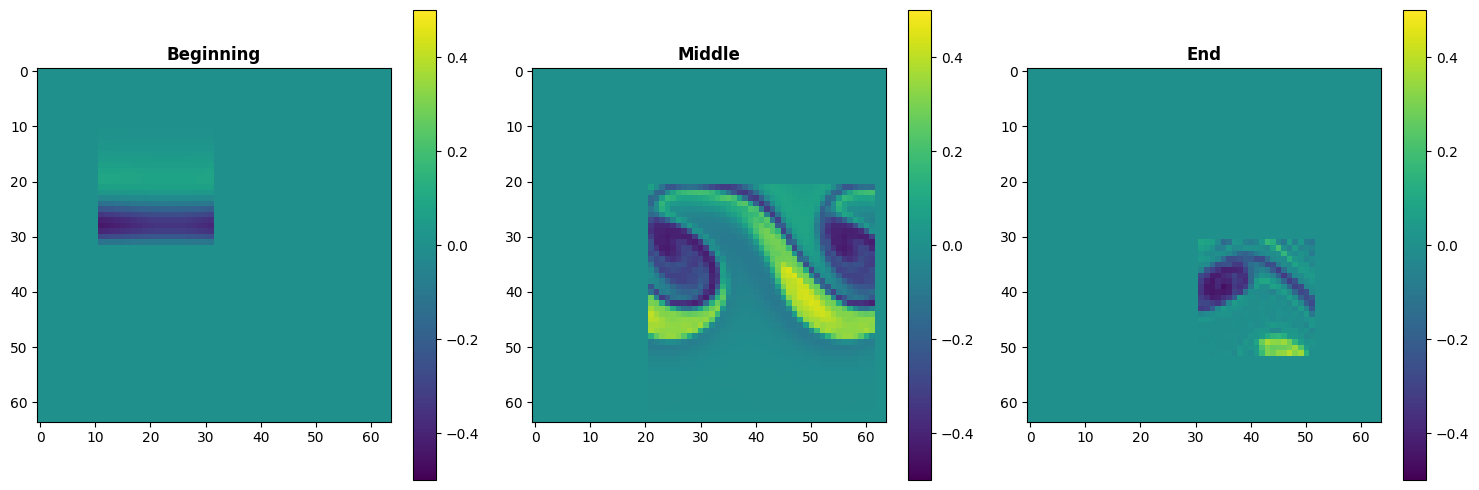

In [42]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(ma[0,:,:,0], vmin = -0.5, vmax = 0.5)
plt.title('Beginning', fontweight = 'bold')
plt.colorbar()

plt.subplot(132)
plt.imshow(ma[1000,:,:,0], vmin = -0.5, vmax = 0.5)
plt.title('Middle', fontweight = 'bold')
plt.colorbar()

plt.subplot(133)

plt.imshow(ma[1900,:,:,0], vmin = -0.5, vmax = 0.5) #, cmap = 'seismic'
plt.title('End', fontweight = 'bold')
plt.colorbar()

plt.tight_layout()

plt.savefig('cluster')

In [46]:

# split train/val/test
train_data_dict, test_data_dict = train_test_split(ma test_size=0.15)
test_data_dict, valid_data_dict = train_test_split(ma, test_size=0.05)

SyntaxError: invalid syntax (<ipython-input-46-c793f0bfbf8a>, line 2)

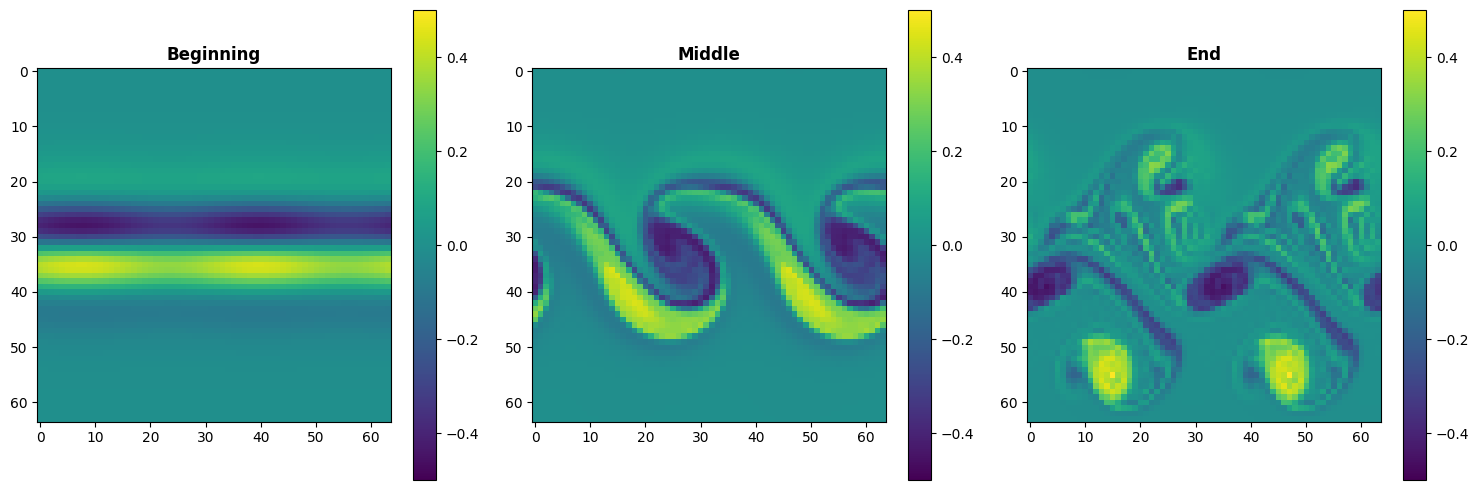

In [47]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(dataset[0,:,:,0], vmin = -0.5, vmax = 0.5)
plt.title('Beginning', fontweight = 'bold')
plt.colorbar()

plt.subplot(132)
plt.imshow(dataset[1000,:,:,0], vmin = -0.5, vmax = 0.5)
plt.title('Middle', fontweight = 'bold')
plt.colorbar()

plt.subplot(133)

plt.imshow(dataset[1900,:,:,0], vmin = -0.5, vmax = 0.5) #, cmap = 'seismic'
plt.title('End', fontweight = 'bold')
plt.colorbar()

plt.tight_layout()

plt.savefig('pre_cluster')

# network

In [48]:
class ResidualStack(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(ResidualStack, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._layers = []
    for i in range(num_residual_layers):
      conv3 = snt.Conv2D(
          output_channels=num_residual_hiddens,
          kernel_shape=(3, 3),
          stride=(1, 1),
          name="res3x3_%d" % i)
      conv1 = snt.Conv2D(
          output_channels=num_hiddens,
          kernel_shape=(1, 1),
          stride=(1, 1),
          name="res1x1_%d" % i)
      self._layers.append((conv3, conv1))

  def __call__(self, inputs):
    h = inputs
    for conv3, conv1 in self._layers:
      conv3_out = conv3(tf.nn.relu(h))
      conv1_out = conv1(tf.nn.relu(conv3_out))
      h += conv1_out
    return tf.nn.relu(h)  # Resnet V1 style


class Encoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Encoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._enc_1 = snt.Conv2D(
        output_channels=self._num_hiddens // 2,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_1")
    self._enc_2 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_2")
    self._enc_3 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="enc_3")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)

  def __call__(self, x):
    h = tf.nn.relu(self._enc_1(x))
    h = tf.nn.relu(self._enc_2(h))
    h = tf.nn.relu(self._enc_3(h))
    return self._residual_stack(h)


class Decoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Decoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._dec_1 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="dec_1")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)
    self._dec_2 = snt.Conv2DTranspose(
        output_channels=self._num_hiddens // 2,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_2")
    self._dec_3 = snt.Conv2DTranspose(
        output_channels=3,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_3")

  def __call__(self, x):
    h = self._dec_1(x)
    h = self._residual_stack(h)
    h = tf.nn.relu(self._dec_2(h))
    x_recon = self._dec_3(h)
    return x_recon


class VQVAEModel(snt.Module):
  def __init__(self, encoder, decoder, vqvae, pre_vq_conv1,
               data_variance, name=None):
    super(VQVAEModel, self).__init__(name=name)
    self._encoder = encoder
    self._decoder = decoder
    self._vqvae = vqvae
    self._pre_vq_conv1 = pre_vq_conv1
    self._data_variance = data_variance

  def __call__(self, inputs, is_training):
    z = self._pre_vq_conv1(self._encoder(inputs))
    vq_output = self._vqvae(z, is_training=is_training)
    x_recon = self._decoder(vq_output['quantize'])
    recon_error = tf.reduce_mean((x_recon - inputs) ** 2) / self._data_variance
    loss = recon_error + vq_output['loss']
    return {
        'z': z,
        'x_recon': x_recon,
        'loss': loss,
        'recon_error': recon_error,
        'vq_output': vq_output,
    }

In [49]:
# Set hyper-parameters.
batch_size = nx
image_size = nx

# 100k steps should take < 30 minutes on a modern (>= 2017) GPU.
# 10k steps gives reasonable accuracy with VQVAE on Cifar10.
num_training_updates = 10000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
# These hyper-parameters define the size of the model (number of parameters and layers).
# The hyper-parameters in the paper were (For ImageNet):
# batch_size = 128
# image_size = 128
# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2

# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 64

# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 512

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4


# # Data Loading.
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_data_dict)
    .map(cast_and_normalise_images)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size, drop_remainder=True)
    .prefetch(-1))

valid_dataset = (
    tf.data.Dataset.from_tensor_slices(valid_data_dict)
    .map(cast_and_normalise_images)
    .repeat(1)  # 1 epoch
    .batch(batch_size)
    .prefetch(-1))

# # Build modules.
encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)

model = VQVAEModel(encoder, decoder, vq_vae, pre_vq_conv1,
                   data_variance=train_data_variance)

optimizer = snt.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(data):
  with tf.GradientTape() as tape:
    model_output = model(data, is_training=True)
  trainable_variables = model.trainable_variables
  grads = tape.gradient(model_output['loss'], trainable_variables)
  optimizer.apply(grads, trainable_variables)

  return model_output

train_losses = []
train_recon_errors = []
train_perplexities = []
train_vqvae_loss = []

for step_index, data in enumerate(train_dataset):

  train_results = train_step(data)
  train_losses.append(train_results['loss'])
  train_recon_errors.append(train_results['recon_error'])
  train_perplexities.append(train_results['vq_output']['perplexity'])
  train_vqvae_loss.append(train_results['vq_output']['loss'])

  if (step_index + 1) % 100 == 0:
    print('%d train loss: %f ' % (step_index + 1,
                                   np.mean(train_losses[-100:])) +
          ('recon_error: %.3f ' % np.mean(train_recon_errors[-100:])) +
          ('perplexity: %.3f ' % np.mean(train_perplexities[-100:])) +
          ('vqvae loss: %.3f' % np.mean(train_vqvae_loss[-100:])))
  if step_index == num_training_updates:
    break

100 train loss: 0.394753 recon_error: 0.357 perplexity: 14.690 vqvae loss: 0.038
200 train loss: 0.157618 recon_error: 0.132 perplexity: 19.905 vqvae loss: 0.026
300 train loss: 0.118139 recon_error: 0.097 perplexity: 20.616 vqvae loss: 0.021
400 train loss: 0.093110 recon_error: 0.075 perplexity: 21.430 vqvae loss: 0.018
500 train loss: 0.077996 recon_error: 0.062 perplexity: 22.987 vqvae loss: 0.016
600 train loss: 0.066570 recon_error: 0.052 perplexity: 25.189 vqvae loss: 0.015
700 train loss: 0.058115 recon_error: 0.045 perplexity: 26.018 vqvae loss: 0.013
800 train loss: 0.050479 recon_error: 0.039 perplexity: 27.514 vqvae loss: 0.012
900 train loss: 0.044539 recon_error: 0.034 perplexity: 29.311 vqvae loss: 0.011
1000 train loss: 0.039926 recon_error: 0.030 perplexity: 30.783 vqvae loss: 0.010
1100 train loss: 0.035970 recon_error: 0.027 perplexity: 31.799 vqvae loss: 0.009
1200 train loss: 0.032280 recon_error: 0.024 perplexity: 32.549 vqvae loss: 0.008
1300 train loss: 0.029438

In [ ]:
# dataset_noise=valid_data_dict+np.float32(np.random.uniform(-0.05,0.05,valid_data_dict.shape))

# out = model(dataset_noise, is_training = False)

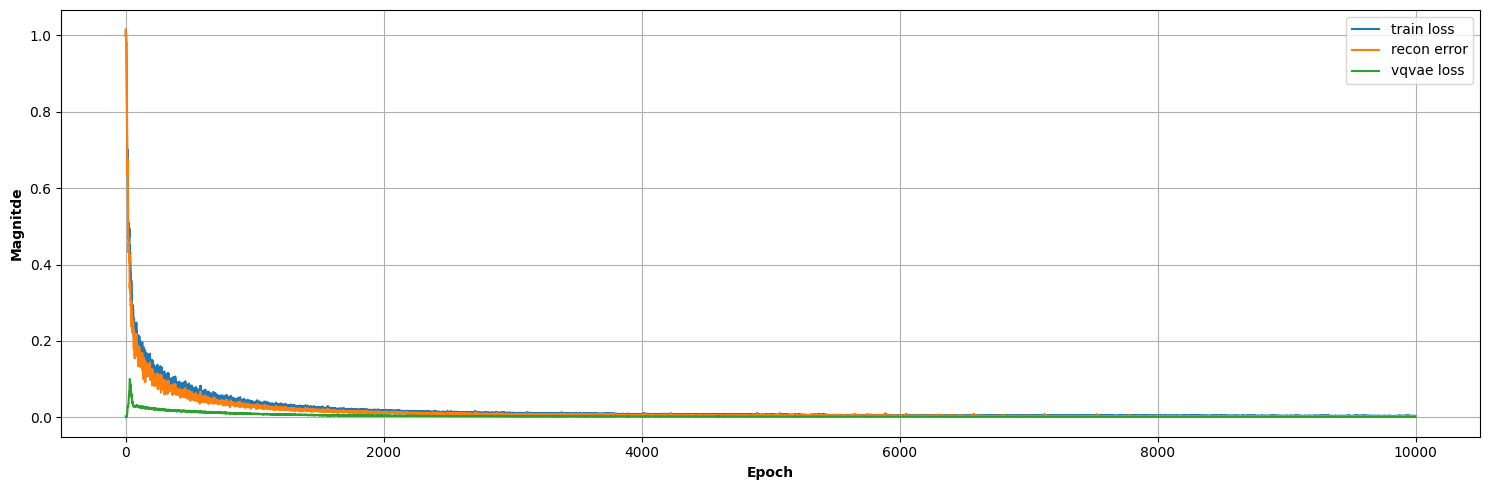

In [50]:
plt.figure(figsize = (15,5))

plt.plot(train_losses, label = 'train loss')
plt.plot(train_recon_errors, label = 'recon error')
plt.plot(train_vqvae_loss, label = 'vqvae loss')

plt.grid()
plt.legend()
plt.xlabel('Epoch', fontweight = 'bold')
plt.ylabel('Magnitde', fontweight = 'bold')

plt.tight_layout()

plt.savefig('losses_cluster')

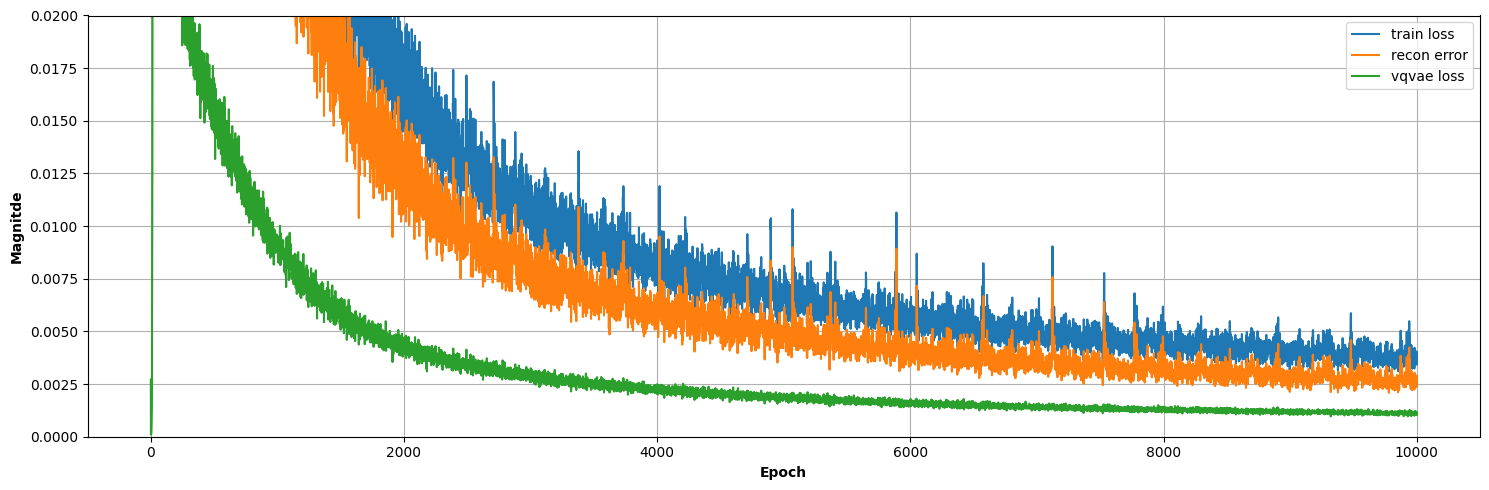

In [51]:
plt.figure(figsize = (15,5))

plt.plot(train_losses, label = 'train loss')
plt.plot(train_recon_errors, label = 'recon error')
plt.plot(train_vqvae_loss, label = 'vqvae loss')

plt.grid()
plt.legend()
plt.xlabel('Epoch', fontweight = 'bold')
plt.ylabel('Magnitde', fontweight = 'bold')
plt.ylim([0, 0.02])

plt.tight_layout()

plt.savefig('losses_zoom_cluster')

# Evaluate/ rmse

In [52]:
def rmse(a,b):
  return np.sqrt(np.mean((a-b)**2))

In [53]:
dataset_noise=valid_data_dict+np.float32(np.random.uniform(-0.05,0.05,valid_data_dict.shape))

out = model(dataset_noise, is_training = False)
rec_u = out['x_recon'].numpy()
print(rmse(rec_u, valid_data_dict))

0.014322963


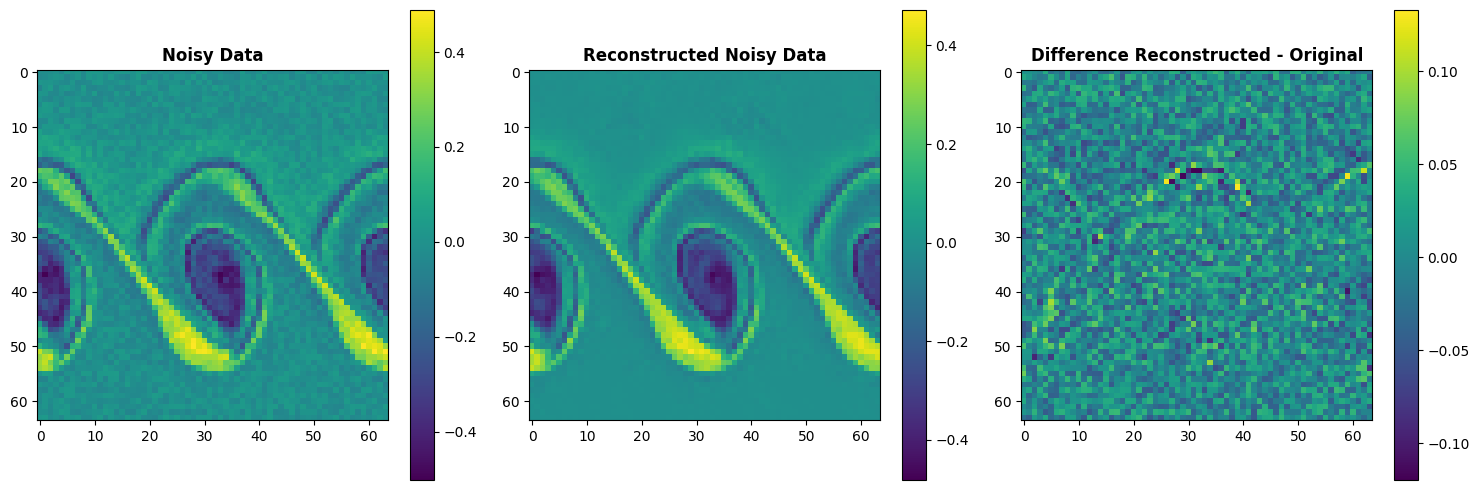

In [54]:
m = 1

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(dataset_noise[m,:,:,0])
plt.title('Noisy Data', fontweight = 'bold')
plt.colorbar()

plt.subplot(132)
plt.imshow(rec_u[m,:,:,0])
plt.title('Reconstructed Noisy Data', fontweight = 'bold')
plt.colorbar()

plt.subplot(133)

plt.imshow(rec_u[m,:,:,0]-dataset_noise[m,:,:,0]) #, cmap = 'seismic'
plt.title('Difference Reconstructed - Original', fontweight = 'bold')
plt.colorbar()

plt.tight_layout()

plt.savefig('noise_recon_cluster')

In [55]:
data_good_1 = dataset[100,:,:,0]
data_good_2 = dataset[1300,:,:,0]
data_good_3 = dataset[-100,:,:,0]

In [56]:
out = model(dataset, is_training = False)
rec_good= out['x_recon'].numpy()

In [57]:
rec_good_1 = rec_good[100,:,:,0]
rec_good_2 = rec_good[1300,:,:,0]
rec_good_3 = rec_good[-100,:,:,0]

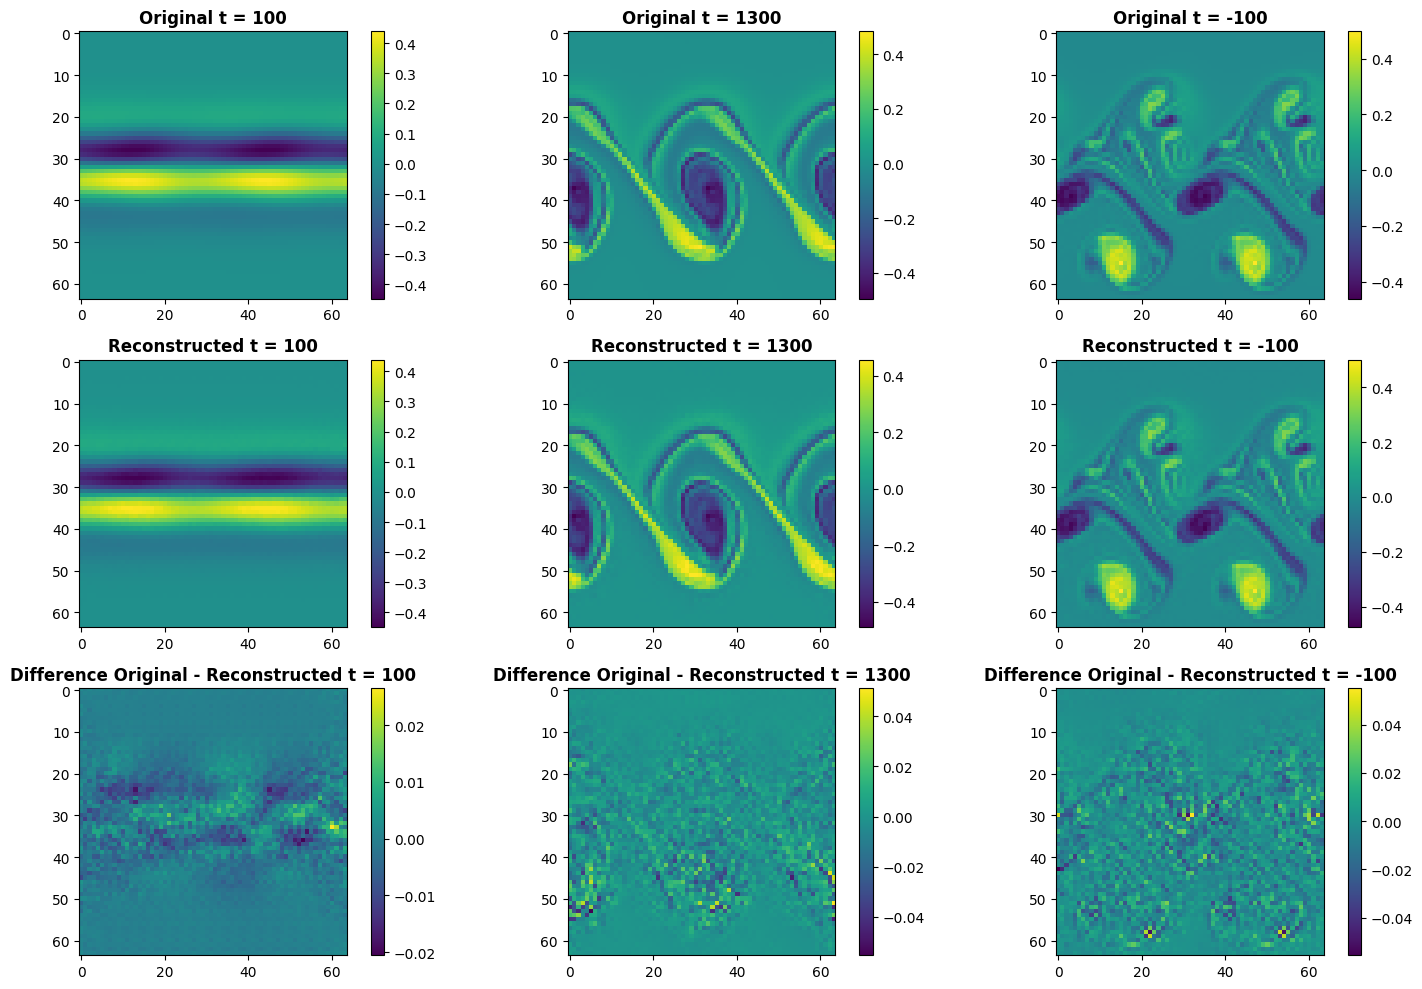

In [58]:
plt.figure(figsize = (15,10))

plt.subplot(331)
plt.imshow(data_good_1)
plt.colorbar()
plt.title('Original t = 100', fontweight = 'bold')

plt.subplot(332)
plt.imshow(data_good_2)
plt.colorbar()
plt.title('Original t = 1300', fontweight = 'bold')

plt.subplot(333)
plt.imshow(data_good_3)
plt.colorbar()
plt.title('Original t = -100', fontweight = 'bold')

plt.subplot(334)
plt.imshow(rec_good_1)
plt.colorbar()
plt.title('Reconstructed t = 100', fontweight = 'bold')

plt.subplot(335)
plt.imshow(rec_good_2)
plt.colorbar()
plt.title('Reconstructed t = 1300', fontweight = 'bold')

plt.subplot(336)
plt.imshow(rec_good_3)
plt.colorbar()
plt.title('Reconstructed t = -100', fontweight = 'bold')

plt.subplot(337)
plt.imshow(data_good_1 - rec_good_1)
plt.colorbar()
plt.title('Difference Original - Reconstructed t = 100', fontweight = 'bold')

plt.subplot(338)
plt.imshow(data_good_2 - rec_good_2)
plt.colorbar()
plt.title('Difference Original - Reconstructed t = 1300', fontweight = 'bold')

plt.subplot(339)
plt.imshow(data_good_3 - rec_good_3)
plt.colorbar()
plt.title('Difference Original - Reconstructed t = -100', fontweight = 'bold')

plt.tight_layout()

plt.savefig('data_good_cluster')

In [60]:
data_bad_1 = dataset_bad[100,:,:,0]
data_bad_2 = dataset_bad[1300,:,:,0]
data_bad_3 = dataset_bad[-100,:,:,0]

In [61]:
out = model(dataset_bad, is_training = False)
rec_bad = out['x_recon'].numpy()

In [62]:
rec_bad_1 = rec_bad[100,:,:,0]
rec_bad_2 = rec_bad[1300,:,:,0]
rec_bad_3 = rec_bad[-100,:,:,0]

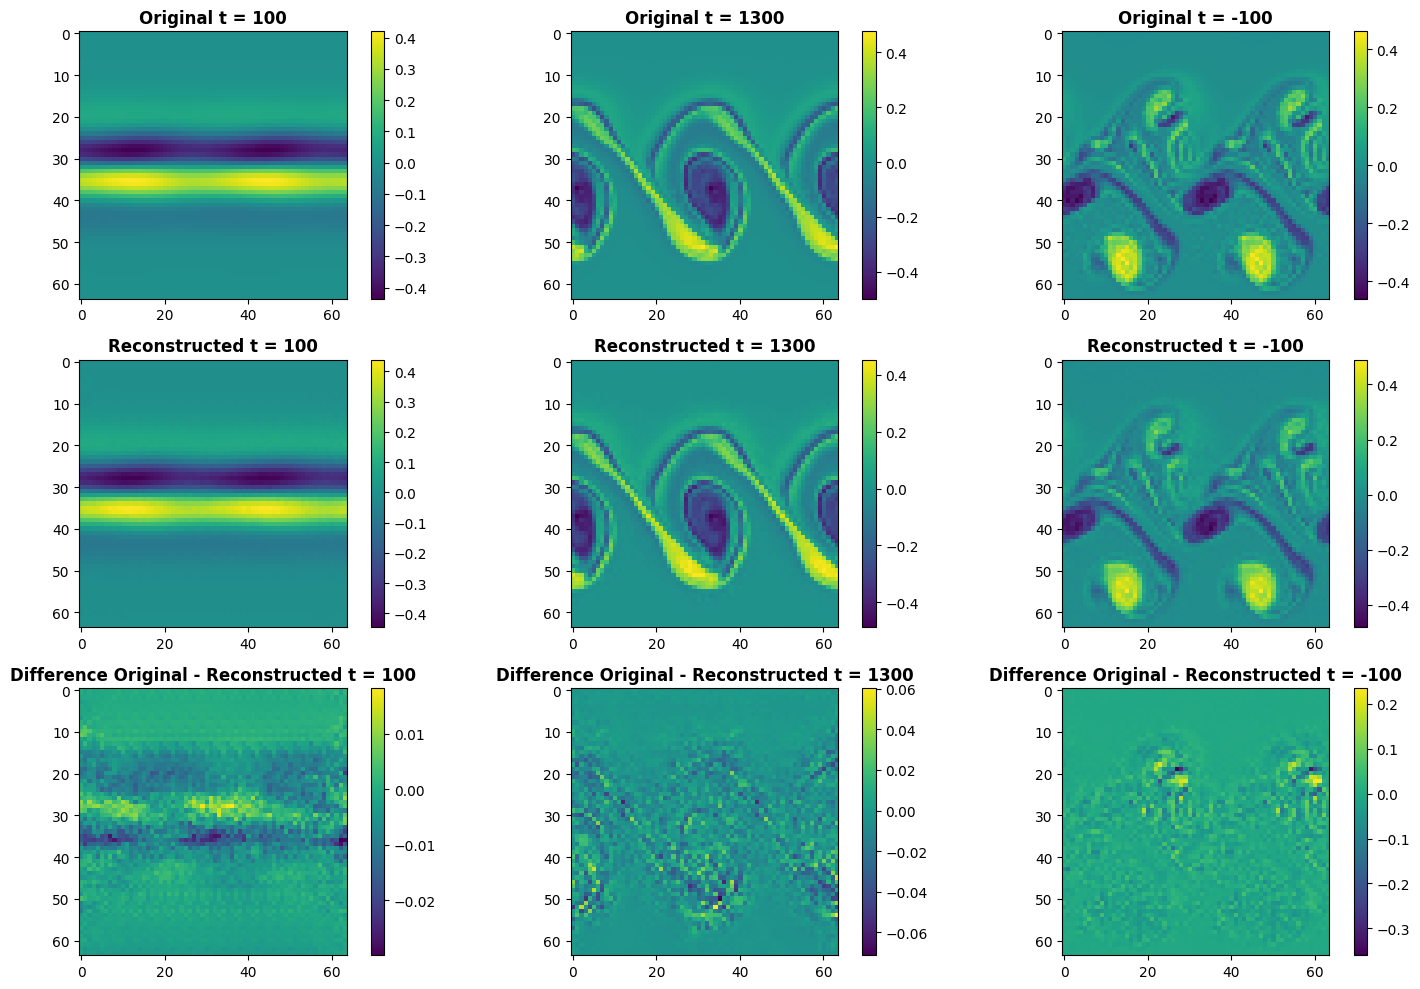

In [63]:
plt.figure(figsize = (15,10))

plt.subplot(331)
plt.imshow(data_bad_1)
plt.colorbar()
plt.title('Original t = 100', fontweight = 'bold')

plt.subplot(332)
plt.imshow(data_bad_2)
plt.colorbar()
plt.title('Original t = 1300', fontweight = 'bold')

plt.subplot(333)
plt.imshow(data_bad_3)
plt.colorbar()
plt.title('Original t = -100', fontweight = 'bold')

plt.subplot(334)
plt.imshow(rec_bad_1)
plt.colorbar()
plt.title('Reconstructed t = 100', fontweight = 'bold')

plt.subplot(335)
plt.imshow(rec_bad_2)
plt.colorbar()
plt.title('Reconstructed t = 1300', fontweight = 'bold')

plt.subplot(336)
plt.imshow(rec_bad_3)
plt.colorbar()
plt.title('Reconstructed t = -100', fontweight = 'bold')

plt.subplot(337)
plt.imshow(data_bad_1 - rec_bad_1)
plt.colorbar()
plt.title('Difference Original - Reconstructed t = 100', fontweight = 'bold')

plt.subplot(338)
plt.imshow(data_bad_2 - rec_bad_2)
plt.colorbar()
plt.title('Difference Original - Reconstructed t = 1300', fontweight = 'bold')

plt.subplot(339)
plt.imshow(data_bad_3 - rec_bad_3)
plt.colorbar()
plt.title('Difference Original - Reconstructed t = -100', fontweight = 'bold')

plt.tight_layout()

plt.savefig('data_bad_cluster')

In [64]:
n = dataset.shape[0]

err_good = np.zeros(n)
err_bad = np.zeros(n)

for i in range(n):

  out = model(dataset[i,None,], is_training = False)
  rec = out['x_recon'].numpy()

  err_good[i] = rmse(rec, dataset[i,None,])

  out = model(dataset_bad[i,None,], is_training = False)
  rec = out['x_recon'].numpy()

  err_bad[i] = rmse(rec, dataset_bad[i, None,])

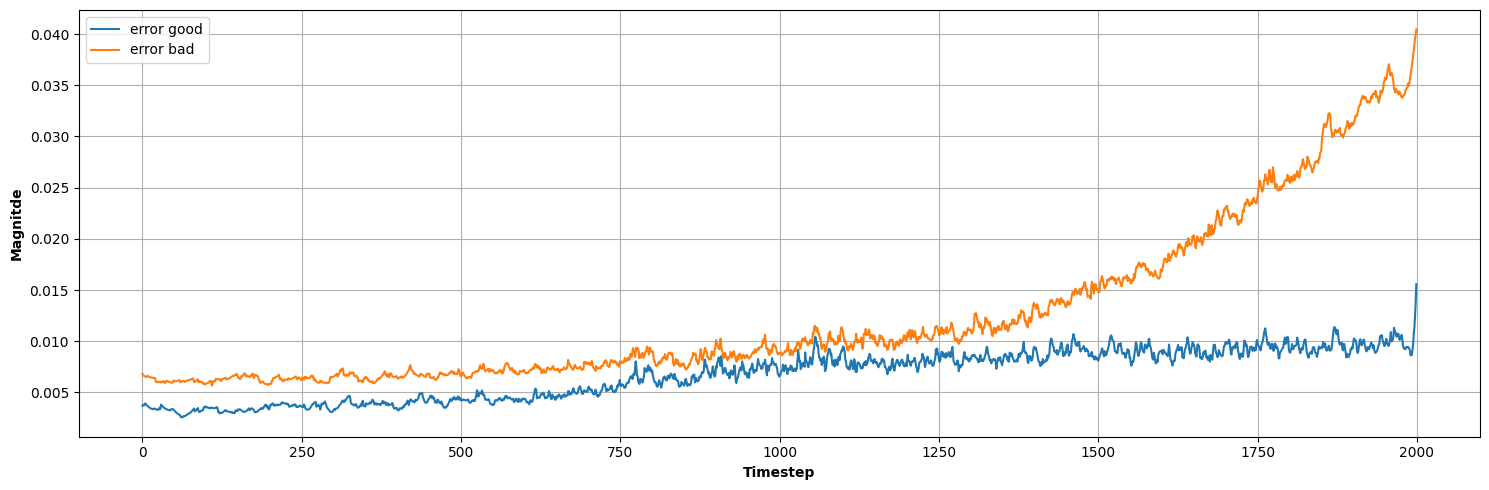

In [67]:
plt.figure(figsize = (15,5))

plt.plot(err_good, label = 'error good')
plt.plot(err_bad, label = 'error bad')

plt.grid()
plt.legend()
plt.xlabel('Timestep', fontweight = 'bold')
plt.ylabel('Magnitde', fontweight = 'bold')

plt.tight_layout()

plt.savefig('rmse_cluster')

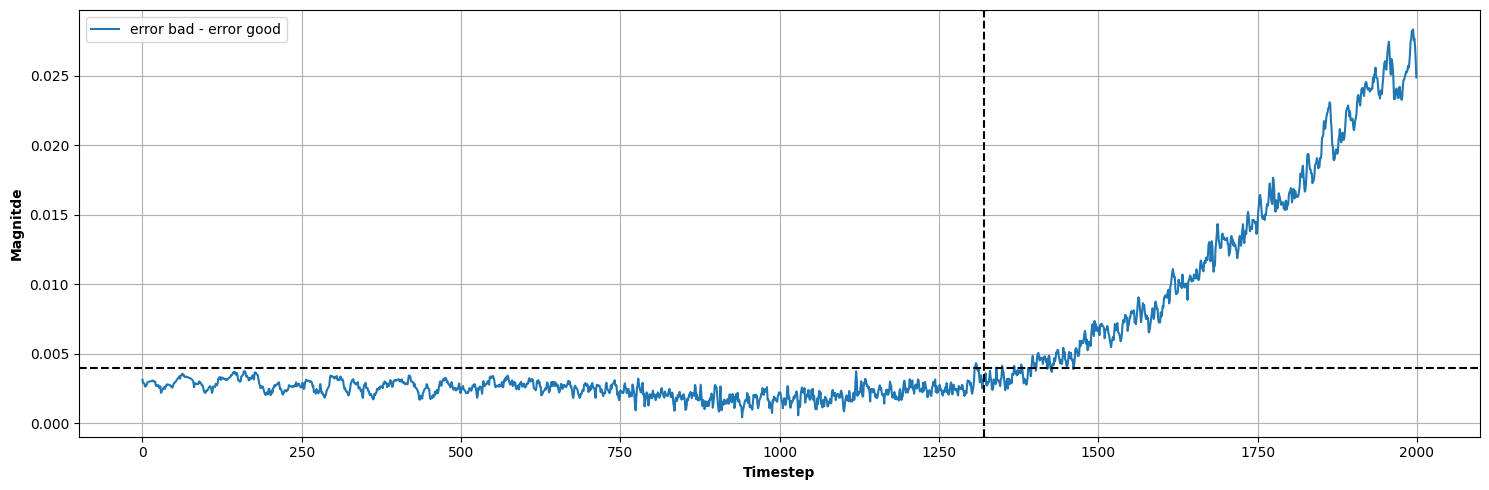

In [68]:
plt.figure(figsize = (15,5))

plt.plot(err_bad-err_good, label = 'error bad - error good')
plt.axhline(0.004, color = 'black', linestyle = '--')
plt.axvline(1320, color = 'black', linestyle = '--')

plt.grid()
plt.legend()
plt.xlabel('Timestep', fontweight = 'bold')
plt.ylabel('Magnitde', fontweight = 'bold')

plt.tight_layout()

plt.savefig('rmse difference_cluster')

In [ ]:
# out = model(valid_data_dict , is_training = False)
# rec_u = out['x_recon'].numpy()
# print(rmse(rec_u, valid_data_dict))

# rec_test_data = cvae.predict(x_test)
# print(rmse(rec_test_data,y_test))

In [ ]:
image_1 = dataset_bad[100]
image_2 = dataset_bad[1300]
image_3 = dataset_bad[-100]

In [ ]:
npix = image_1.shape[0]

fourier_image = np.fft.fftn(image_1)
fourier_amplitudes = np.abs(fourier_image)**2

kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins_1, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins_1 *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

In [ ]:
npix = image_2.shape[0]

fourier_image = np.fft.fftn(image_2)
fourier_amplitudes = np.abs(fourier_image)**2

kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins_2, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins_2 *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

In [ ]:
npix = image_3.shape[0]

fourier_image = np.fft.fftn(image_3)
fourier_amplitudes = np.abs(fourier_image)**2

kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins_3, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins_3 *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

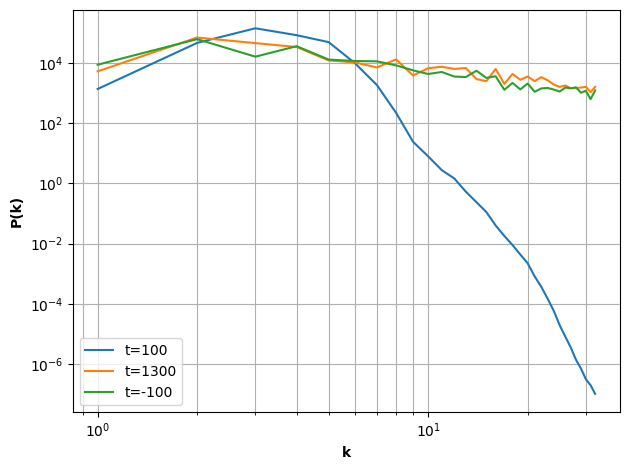

In [ ]:
pl.figure()

pl.loglog(kvals, Abins_1, label = 't=100')
pl.loglog(kvals, Abins_2, label = 't=1300')
pl.loglog(kvals, Abins_3, label = 't=-100')

pl.grid(True, which = 'both')
pl.legend()
pl.xlabel("k", fontweight = 'bold')
pl.ylabel("P(k)", fontweight = 'bold')

pl.tight_layout()

pl.savefig('spectrum')